<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM Àrea 4 · NLP & Text Mining</p>
<p style="margin: 0; text-align:right;">2022 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="row" style="padding-top: 50px;">
    <div class="row" style="background: #494949;padding: 10px 20px; color: #FFF">
        <div class="col-md-12">
            <div style="text-align:left;"><b>Estudiant:</b> Albert Cámara Viñals</div>
        </div>
    </div>
</div>

## T8 - Information Extraction from *synthetic invoice* with *LayoutLMv2* model (inference)

## **Information extraction**

> Information extraction (IE) is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources. In most of the cases this activity concerns processing images by means computer vision (CV) and processing human language texts by means of natural language processing (NLP).

In [1]:
# Load libraries
import cv2
import glob
import json
import pandas as pd
import pickle
import math
import networkx as nx
import numpy as np
import os
import torch
import re
import seaborn as sns
import shutil
import warnings

from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor

from torch.utils.data import Dataset, DataLoader

from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, AdamW
from transformers import logging

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

logging.set_verbosity_error()
warnings.filterwarnings("ignore")

## Data Objects

### Define some data models

In [2]:
class InvoiceDataset(Dataset):
    """Invoice dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (dataframe): Dataframe containing the word-level annotations (filename, words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.image_file_names = annotations['file'].tolist()
        self.words = annotations['words'].tolist() 
        self.labels = annotations['labels'].tolist() 
        self.boxes = annotations['boxes'].tolist()
        self.image_dir = image_dir
        self.processor = processor
        
        #print(len(self.image_file_names), ' ', len(self.words), ' ', len(self.labels), ' ', len(self.boxes))

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
          
        # word_labels = [label2id[label] for label in word_labels]
        
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, padding="max_length", truncation=True, return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [3]:
class Item:
    
    def __init__(self, bbox, content, tag):
        self.bbox = bbox
        self.content = content
        self.tag = tag

In [4]:
class Invoice:
    
    def __init__(self):
        self.billing_address = None
        self.billing_contact_number = None
        self.billing_name = None
        self.client_number = None
        self.image = None
        self.invoice_date = None
        self.invoice_number = None
        self.order_number = None
        self.payment_mode = None
        self.shipping_address = None
        self.shipping_name = None
        self.supplier_address = None
        self.supplier_contact_number = None
        self.supplier_fax_number = None
        self.supplier_id = None
        self.supplier_name = None
        self.supplier_siret = None
        self.supplier_vat = None
        self.tax_rate = None
        self.total_amount = None
        self.total_tax = None
        self.total_without_tax = None
        self.line_items = None
        
    def set_field(self, field, value):
        if field == 'BILLING_ADDRESS':
            self.billing_address = merge_text(self.billing_address, value)
        elif field == 'BILLING_CONTACT_NUMBER':
            self.billing_contact_number = merge_text(self.billing_contact_number, value)
        elif field == 'BILLING_NAME':
            self.billing_name = merge_text(self.billing_name, value)
        elif field == 'CLIENT_NUMBER': 
            self.client_number = merge_text(self.client_number, value)
        elif field == 'IMAGE':  
            self.image = merge_text(self.image, value)
        elif field == 'INVOICE_DATE':  
            self.invoice_date = merge_text(self.invoice_date, value)
        elif field == 'INVOICE_NUMBER':  
            self.invoice_number = merge_text(self.invoice_number, value)
        elif field == 'ORDER_NUMBER':  
            self.order_number = merge_text(self.order_number, value)
        elif field == 'PAYMENT_MODE':  
            self.payment_mode = merge_text(self.payment_mode, value)
        elif field == 'SHIPPING_ADDRESS':
            self.shipping_address = merge_text(self.shipping_address, value)
        elif field == 'SHIPPING_NAME':
            self.shipping_name = merge_text(self.shipping_name, value)
        elif field == 'SNO':  
            self.sno = merge_text(self.sno, value)
        elif field == 'SUPPLIER_ADDRESS':  
            self.supplier_address = merge_text(self.supplier_address, value)
        elif field == 'SUPPLIER_CONTACT_NUMBER':  
            self.supplier_contact_number = merge_text(self.supplier_contact_number, value)
        elif field == 'SUPPLIER_FAX_NUMBER':  
            self.supplier_fax_number = merge_text(self.supplier_fax_number, value)
        elif field == 'SUPPLIER_ID':  
            self.supplier_id = merge_text(self.supplier_id, value)
        elif field == 'SUPPLIER_NAME':  
            self.supplier_name = merge_text(self.supplier_name, value)
        elif field == 'SUPPLIER_SIRET':  
            self.supplier_siret = merge_text(self.supplier_siret, value)
        elif field == 'SUPPLIER_VAT':  
            self.supplier_vat = merge_text(self.supplier_vat, value)
        elif field == 'TAX_RATE':  
            self.tax_rate = merge_text(self.tax_rate, value)
        elif field == 'TOTAL_AMOUNT':  
            self.total_amount = merge_text(self.total_amount, value)
        elif field == 'TOTAL_TAX':  
            self.total_tax = merge_text(self.total_tax, value)
        elif field == 'TOTAL_WITHOUT_TAX':  
            self.total_without_tax = merge_text(self.total_without_tax, value)
    
    def add_line_items(self, line_items):        
        self.line_items = line_items
    
    def get_json(self):
        return to_json(self)

In [5]:
class InvoiceLine:
    
    def __init__(self, bbox):
        self.bbox = bbox
        self.quantity = None
        self.description = None
        self.unit_price = None
        self.total_price_without_tax = None
        self.total_price_with_tax = None
        self.tax_rate = None
        self.sno = None
        
        
    def set_field(self, field, value):
        if field == 'QUANTITY':
            self.quantity = value
        elif field == 'PRODUCT_DESCRIPTION':
            self.description = value
        elif field == 'UNIT_PRICE':
            self.unit_price = value
        elif field == 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX': 
            self.total_price_without_tax = value
        elif field == 'PRODUCT_TOTAL_PRICE_WITH_TAX': 
            self.total_price_with_tax = value
        elif field == 'TAX_RATE':  
            self.tax_rate = value
        elif field == 'SNO':  
            self.sno = value
    
    def set_bbox(self, bbox):
        self.bbox = bbox
    
    def get_json(self):
        return to_json(self.__dict__)

### Define some functions

In [6]:
def normalize_bbox(x1, y1, x3, y3, width, height):
    bbox = [
        int(1000 * (x1 / width)),
        int(1000 * (y1 / height)),
        int(1000 * (x3 / width)),
        int(1000 * (y3 / height)),
    ]
    
    return bbox

In [7]:
def unnormalize_bbox(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [8]:
def hex2rgba_color(hex, alpha=85):
    c = ImageColor.getcolor(hex, "RGBA")
    y = list(c)
    y[3] = alpha
    
    return tuple(y)

In [9]:
def gen_image_predictions(file, df):
    
    image = Image.open(file)
    image = image.convert("RGBA")

    overlay = Image.new('RGBA', image.size, (255,255,255,0))

    draw = ImageDraw.Draw(overlay)
    font = ImageFont.truetype("arial.ttf", size=14)

    for idx, row in df.iterrows():
        bbox = unnormalize_bbox(row['bbox'], image.size[0], image.size[1])

        color = (0, 255, 0, 85) if row['target'] == row['target_predicted'] else (255, 0, 0, 85)

        draw.rectangle(bbox, fill=color, outline=color, width=2)
        draw.text((bbox[0], bbox[1] - 20), text=row['target_predicted'], fill='blue', font=font)

    overlayed_image = Image.alpha_composite(image, overlay)    
    
    return overlayed_image


In [10]:
def gen_colored_image_predictions(file, df):
    image = Image.open(file)
    image = image.convert("RGBA")

    overlay = Image.new('RGBA', image.size, (255,255,255,0))

    draw = ImageDraw.Draw(overlay)
    font = ImageFont.truetype("arial.ttf", size=14)

    for idx, row in df.iterrows():
        bbox = unnormalize_bbox(row['bbox'], image.size[0], image.size[1])

        color = hex2rgba_color(label2color[row['target_predicted']])

        draw.rectangle(bbox, fill=color, outline=color, width=2)
        draw.text((bbox[0], bbox[1] - 20), text=row['target_predicted'], fill='blue', font=font)

    overlayed_image = Image.alpha_composite(image, overlay)    

    return overlayed_image

In [11]:
def process_file_to_layoutlmv2_data(filepath):
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    basename = os.path.splitext(filename)[0]
    
    # Read dataframe
    df = pd.read_csv(filepath, sep=';')
        
    # Delete rows with text outside of page
    df = df[df['x1'] > 0]
    df = df[df['x3'] < df['page_width']]
    #df = df[df['y3'] < df['page_height']]
    
    # Delete rows with null content and reset index
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    df['normalize_bbox'] = df.apply((lambda x: normalize_bbox(x['x1'], x['y1'], x['x3'], x['y3'], x['page_width'], x['page_height'])),axis=1)
    df['tag_id'] = df.apply(lambda x: label2id.get(x['tag']), axis=1)
    
    words = df['contents'].tolist()
    boxes = df['normalize_bbox'].tolist()
    labels = df['tag_id'].tolist()
    
    return words, labels, boxes

In [12]:
def preprocess_subset_data(df, dataset_path, transfomed_data_path, subsetname):
    print('Preprocessing data for: ', subsetname)
    
    df = df.sort_values(by=['file'])
    
    # Creating an empty Dataframe with column names only
    df_annotations = pd.DataFrame(columns=['file', 'words', 'labels', 'boxes'])
    
    dst_path = os.path.join(dataset_path, subsetname, 'image')
    
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
            
    words = [] 
    labels = []
    boxes = []

    for index, row in df.iterrows():
        file = row['file']
        image = row['image']
        provider = row['provider']
        #print(file, image, provider)

        shutil.copy(os.path.join(transfomed_data_path, provider, image), dst_path)

        words, labels, boxes = process_file_to_layoutlmv2_data(os.path.join(transfomed_data_path, provider, file))

        df_annotations = df_annotations.append({'file': image, 'words': words, 'labels': labels, 'boxes': boxes}, ignore_index=True)
    
    # df_annotations = df_annotations.sort_values(by=['file'])
    
    # Save all documents annotations to file 
    df_annotations.to_pickle(os.path.join(dataset_path, subsetname +'_df.pkl'))

In [13]:
def to_json(obj):
    return json.dumps(obj, default=lambda obj: obj.__dict__, indent=1, ensure_ascii=False)

def merge_text(text, value):
    return text +  " " + str(value) if text else str(value)

In [14]:
# Generate two text boxes a larger one that covers them
def merge_boxes(box1, box2):
    return [
        min(box1[0], box2[0]), 
        min(box1[1], box2[1]), 
        max(box1[2], box2[2]),
        max(box1[3], box2[3])
    ]

In [15]:
def check_invoice_line_exists(invoice_lines, item):
    for idx, line in enumerate(invoice_lines):
        #print('Check line: ', idx, 'with', item.content, item.tag, item.bbox, line.bbox)
        #print('lt', line.bbox[1], 'lb', line.bbox[3], 'tt', term.bbox[1], 'tb', term.bbox[3])
       
        if line.bbox[1] <= item.bbox[3] and line.bbox[3] >= item.bbox[1]:
            return idx
    
    return -1
    
def extract_invoice_lines(items):
    invoice_lines = []
    
    for item in items:
        
        if item.tag in ['QUANTITY', 'SNO', 'PRODUCT_DESCRIPTION', 'UNIT_PRICE', 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX', 'PRODUCT_TOTAL_PRICE_WITH_TAX', 'TAX_RATE']:
            line_idx = check_invoice_line_exists(invoice_lines, item);
            
            if line_idx != -1:
                bbox = merge_boxes(invoice_lines[line_idx].bbox, item.bbox)
                invoice_lines[line_idx].set_field(item.tag, item.content)
                #invoice_lines[line_idx].set_bbox(bbox)
            else:
                invoice_line = InvoiceLine(item.bbox)
                invoice_line.set_field(item.tag, item.content)
                invoice_lines.append(invoice_line)
                
    return invoice_lines

In [16]:
def convert_extracted_data_to_invoice(df):
    # Extract bbox points
    df['x1'] = df.apply(lambda x: x['bbox'][0], axis=1)
    df['y1'] = df.apply(lambda x: x['bbox'][1], axis=1)
    df['x2'] = df.apply(lambda x: x['bbox'][2], axis=1)
    df['y2'] = df.apply(lambda x: x['bbox'][3], axis=1)

    # Sort words based on Top coordinate
    # Sort dataframe by top row and top column (0,0) (left, top)
    df.sort_values(by=['y1', 'x1'], inplace=True, ascending = [True, True])

    items = []

    term = df.iloc[0]
    item = Item(term['bbox'], term['word'], term['target_predicted'])
    items.append(item)

    for idx in range(1, len(df)):    
        term = df.iloc[idx]
        last_item = items[-1]

        if last_item.tag == term['target_predicted']:
            bbox = merge_boxes(last_item.bbox, term['bbox'])
            text = last_item.content + ' ' + term['word']

            items[-1].bbox = bbox
            items[-1].content= text

            #print('merged', items[-1].content)

        else: 
            item = Item(term['bbox'], term['word'], term['target_predicted'])
            items.append(item)

    # Create an empty invoice
    invoice = Invoice()

    # Add extracted Invoice Fields
    for item in items:    
        if item.tag not in ['OTHER', 'QUANTITY', 'SNO', 'PRODUCT_DESCRIPTION', 'UNIT_PRICE', 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX', 'PRODUCT_TOTAL_PRICE_WITH_TAX', 'TAX_RATE']:
            invoice.set_field(item.tag, item.content)

    invoice_lines = extract_invoice_lines(items)

    invoice.add_line_items(invoice_lines)
    
    return invoice

In [17]:
def process_prediction_results(preds, out_label_ids, labels):
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != -100:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    return out_label_list, preds_list

**Define work directories**

In [18]:
# Define some directories
work_dir = './models/'
data_dir = './data/'
dataset_path = './data/synthetic_invoice/'
transfomed_data_path = './data/synthetic_invoice/transformed/'

**Load a dictionary of Entity attributes**

In [19]:
# Invoice attributes
invoice_attributes_file = open(os.path.join(data_dir, 'invoice_attributes.pickle'), "rb")
invoice_attributes = pickle.load(invoice_attributes_file)
invoice_attributes_file.close()

# Invoice attributes colors
invoice_attributes_colors_file = open(os.path.join(data_dir, 'invoice_attributes_colors.pickle'), "rb")
label2color = pickle.load(invoice_attributes_colors_file)
invoice_attributes_colors_file.close()

# Convert Invoice attributes to tags
tags = [v['tag'] for k, v in invoice_attributes.items()]
tags.sort()

# Create to dictionaries, to convert id to label and label to id
id2label = {v: k for v, k in enumerate(tags)}
label2id = {k: v for v, k in enumerate(tags)}

print('Number of labels:', len(label2id.keys()))

Number of labels: 40


## Making predictions with the model

**Load Model**

In [20]:
# Load saved Model
model = torch.load(os.path.join(work_dir, 'fine-tuned_layoutlmv2_model.pth'))

In [21]:
# Load LayoutLMv2Processor from Huggingface provided by Microsoft
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

In [22]:
# Load preprocessed data for Test subset from a file
test = pd.read_pickle(os.path.join(dataset_path, 'test_df.pkl'))

In [23]:
# Create PyTorch Dataset for Test subset 
test_dataset = InvoiceDataset(annotations=test, image_dir=os.path.join(dataset_path, 'test/image/'), processor=processor)

**Single prediction** (true inference)

In [24]:
# Define a samle index
sample_idx = 300

# Show fileName
print(test.iloc[sample_idx].file)

# Get Encodings for sample_idx
encoding = test_dataset[sample_idx]

# Get PyTorch device if available witH GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Load encodings to device
for k,v in encoding.items():
    encoding[k] = v.unsqueeze(0).to(device)

# Put model in evaluation mode
model.eval()

# Make predictions
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'], token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'], image=encoding['image'])

natureDecouvertes-100.tiff


In [25]:
# Transform model output to predictions
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
ground_truth_labels = [id2label[label] for label in encoding['labels'].squeeze().tolist() if label != -100]
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]

# Check number of results
print('Ground truth targets:', len(ground_truth_labels))
print('Predicted targets:', len(predictions))

Ground truth targets: 162
Predicted targets: 162


In [26]:
# Build a dataframe with the results
sample_words = test.iloc[sample_idx].words
sample_labels = [id2label[id] for id in test.iloc[sample_idx].labels]
sample_boxes = test.iloc[sample_idx].boxes
   
df = pd.DataFrame( {'word': sample_words, 'bbox': sample_boxes, 'target': sample_labels, 'target_predicted': predictions} )

# Preview dataframe
df.head(70)

,word,bbox,target,target_predicted
0,LA,"[516, 37, 543, 54]",SUPPLIER_NAME,SUPPLIER_NAME
1,FANTASIA,"[549, 37, 650, 54]",SUPPLIER_NAME,SUPPLIER_NAME
2,123,"[516, 54, 544, 68]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
3,BD,"[549, 54, 572, 68]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
4,LEON,"[577, 54, 622, 68]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
...,...,...,...,...
65,Boucle,"[258, 332, 298, 343]",PRODUCT_DESCRIPTION,PRODUCT_DESCRIPTION
66,classique,"[302, 332, 358, 343]",PRODUCT_DESCRIPTION,PRODUCT_DESCRIPTION
67,havane,"[362, 332, 406, 343]",PRODUCT_DESCRIPTION,PRODUCT_DESCRIPTION
68,38mm,"[410, 332, 447, 343]",PRODUCT_DESCRIPTION,PRODUCT_DESCRIPTION


## Preview predicted Fields

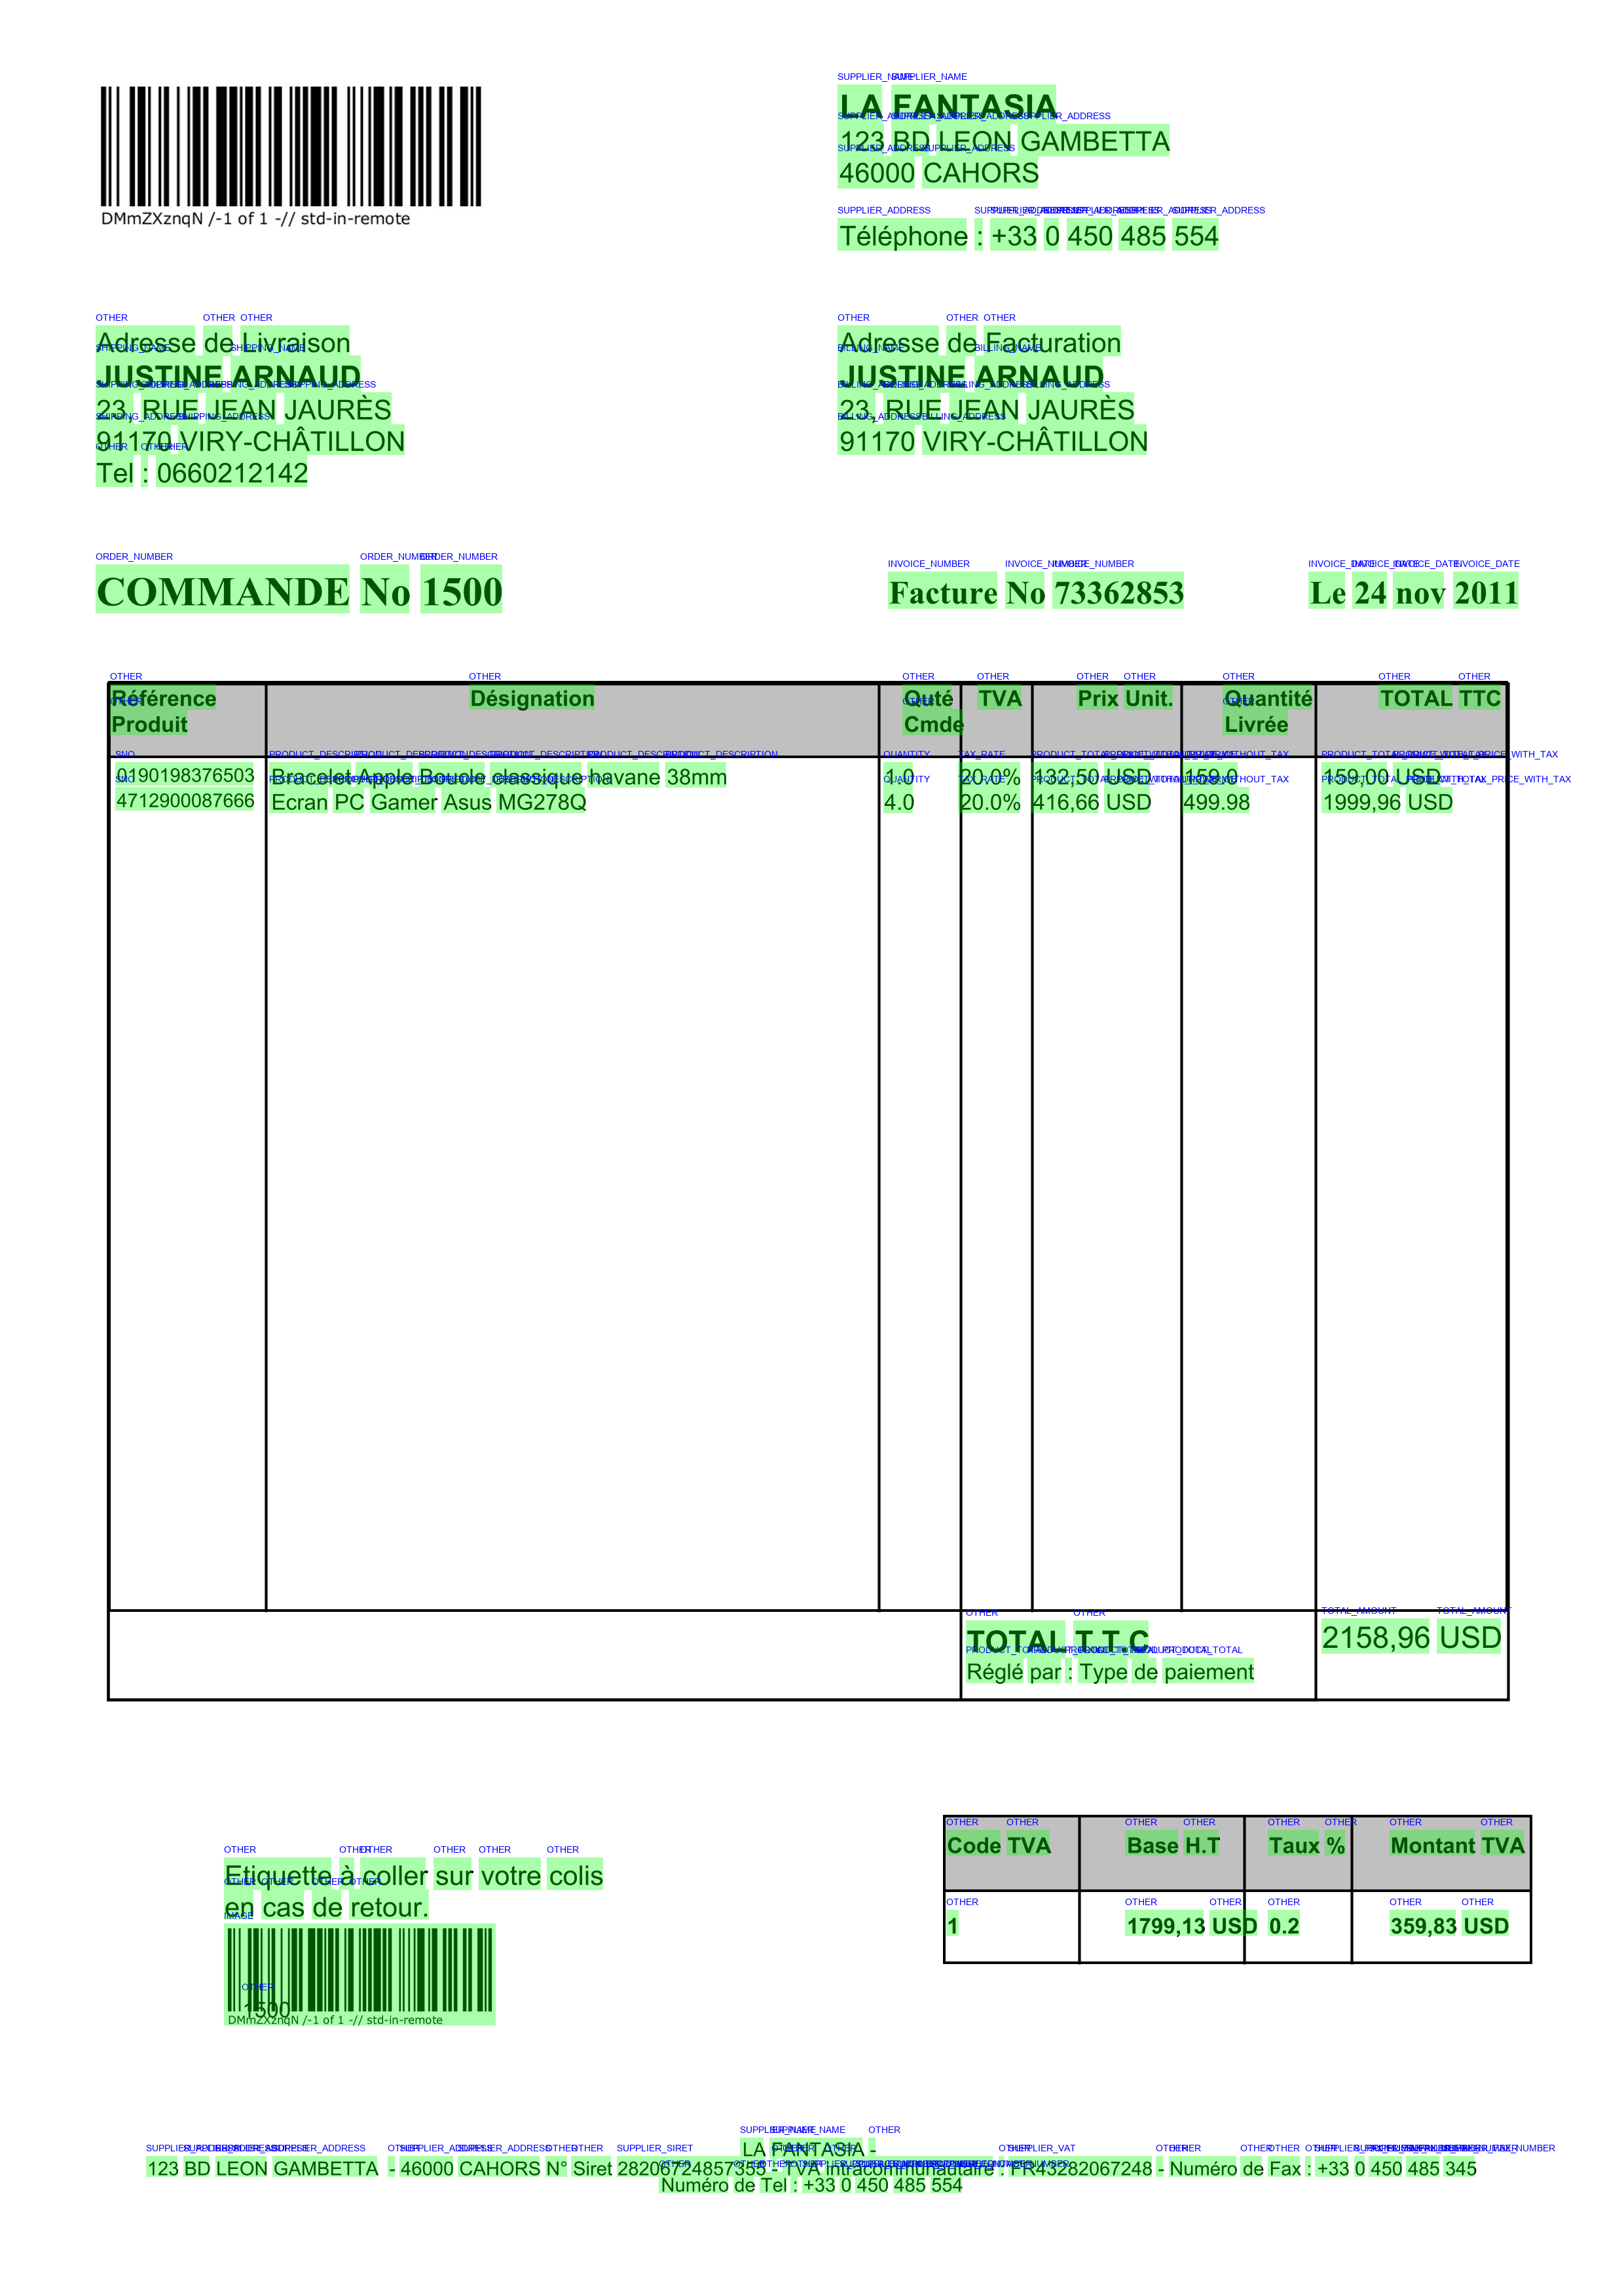

In [27]:
# Show predictions
overlayed_image = gen_image_predictions(os.path.join(data_dir,'synthetic_invoice/test/image/', test.iloc[sample_idx].file), df)

overlayed_image

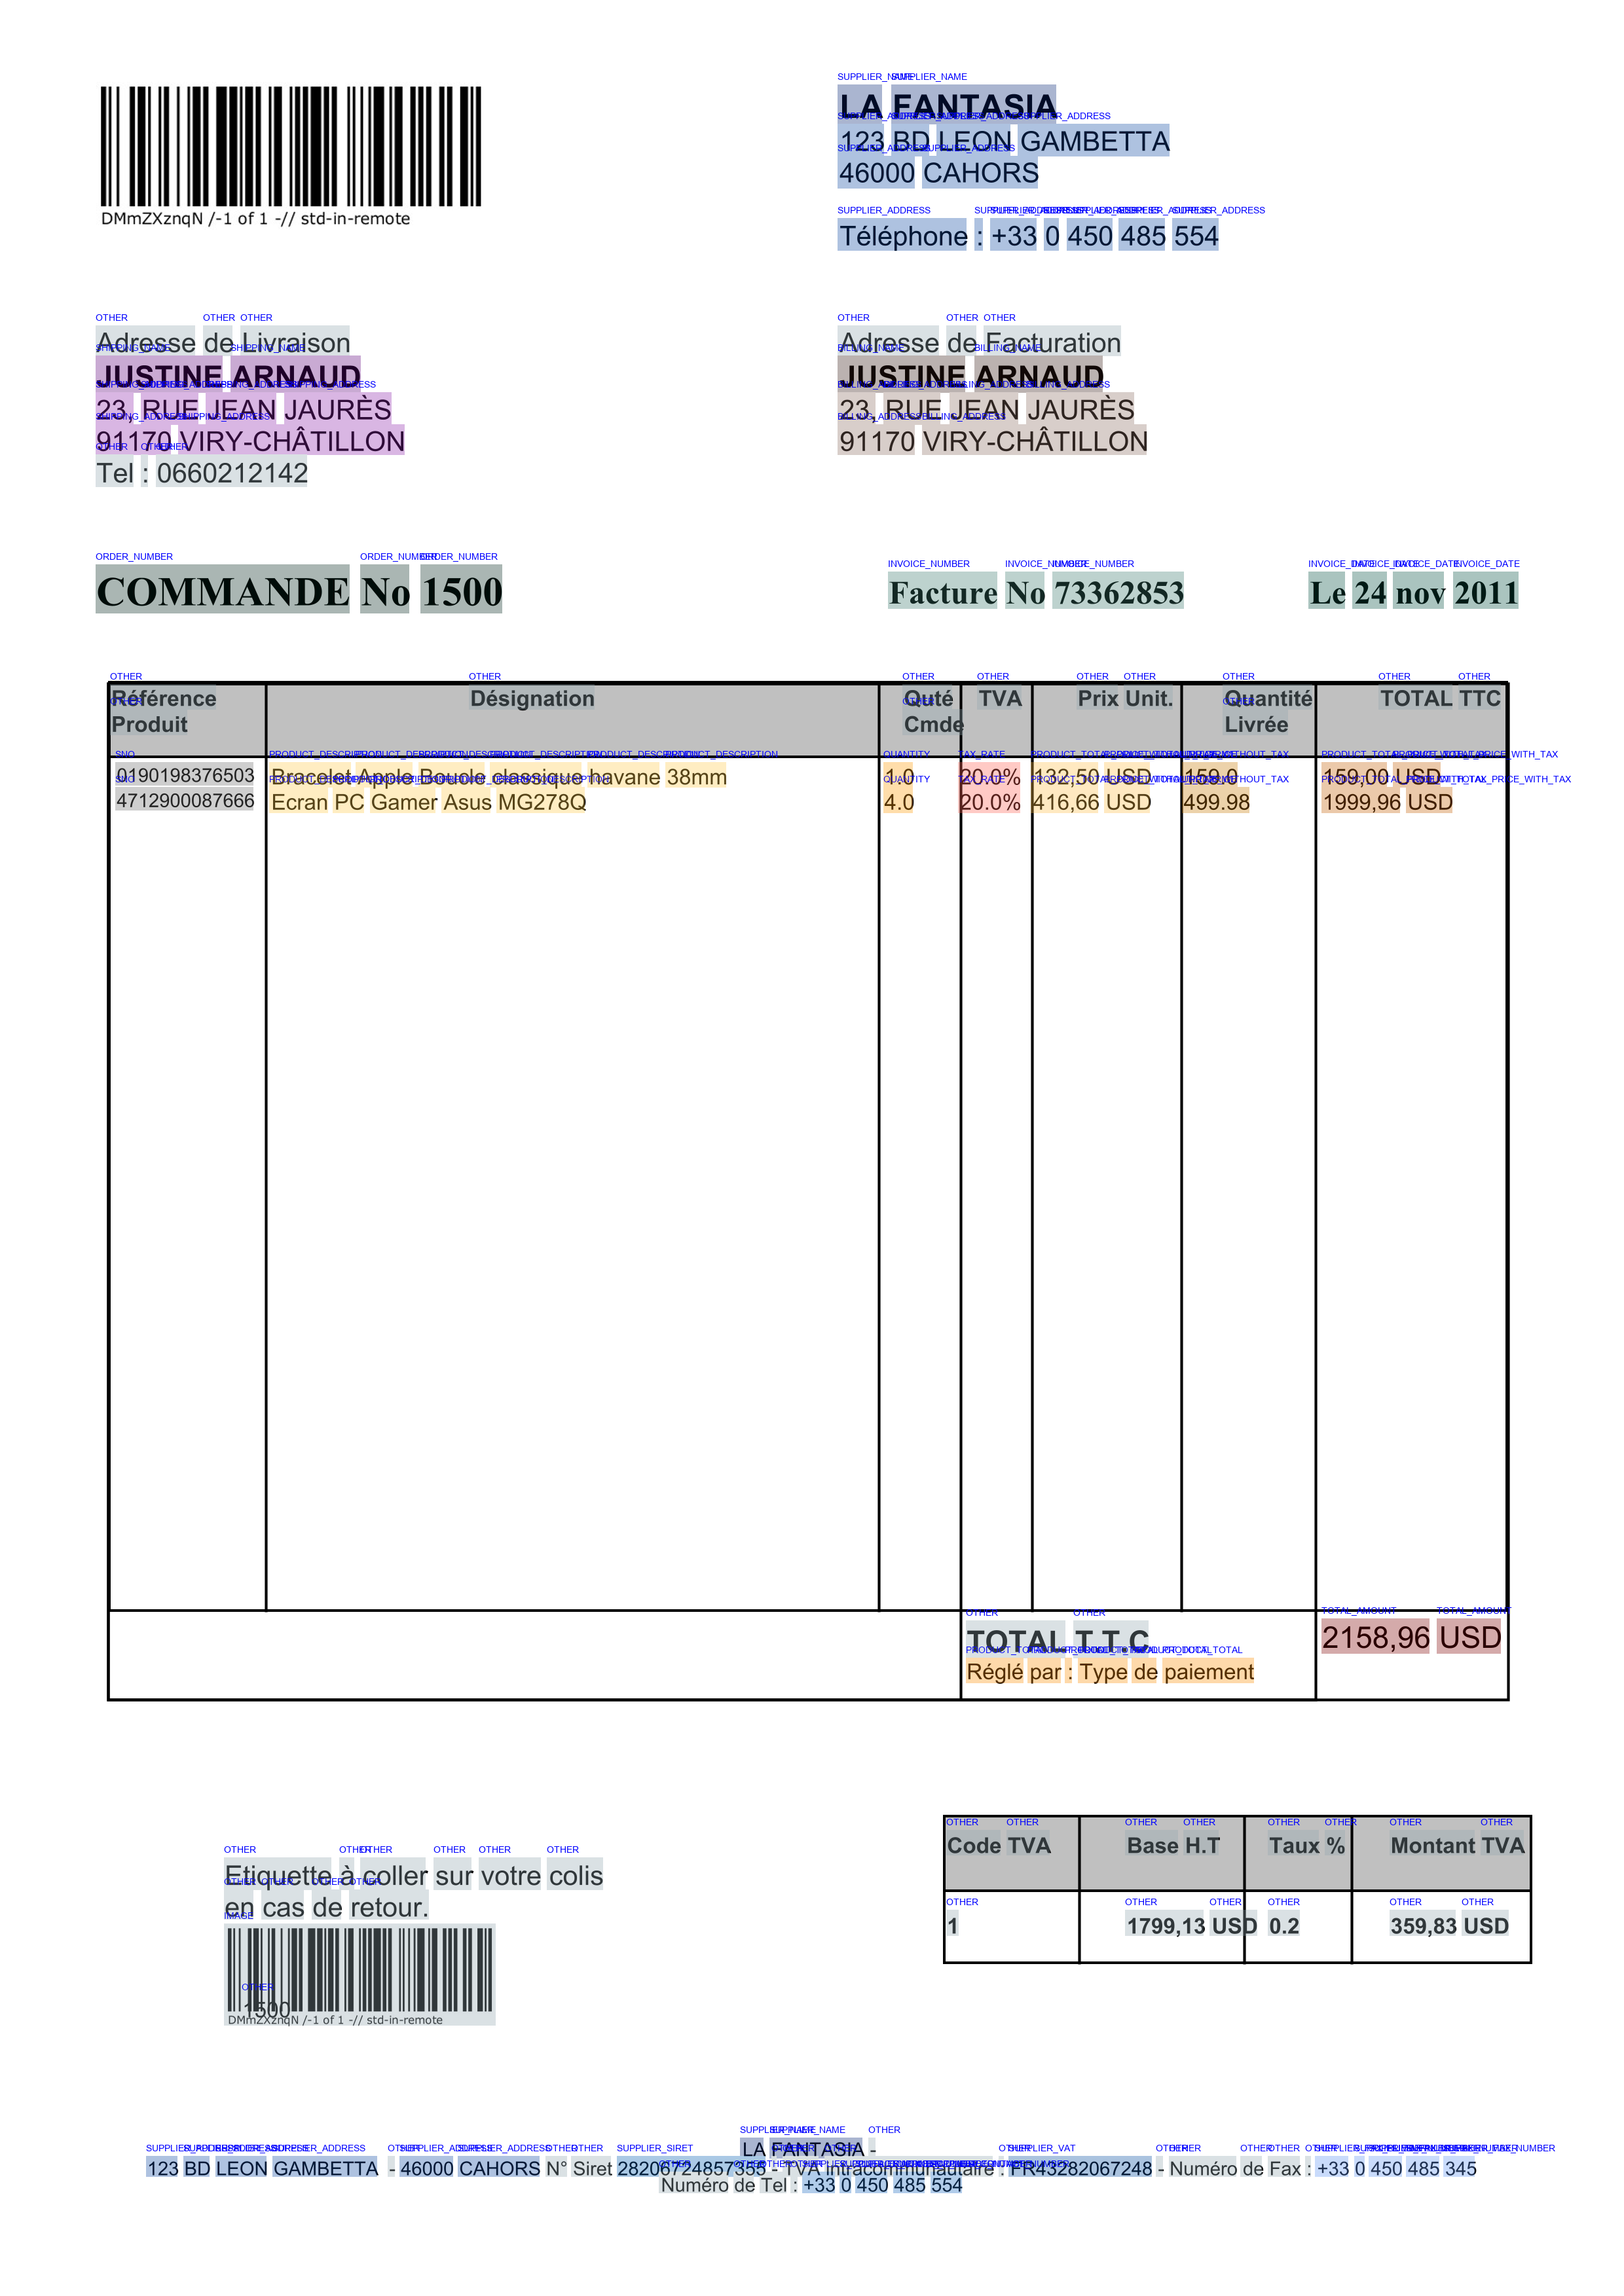

In [28]:
# Show colored predictions by field 
overlayed_image = gen_colored_image_predictions(os.path.join(data_dir,'synthetic_invoice/test/image/', test.iloc[sample_idx].file), df)

overlayed_image

## Extracted Information

In [29]:
invoice = convert_extracted_data_to_invoice(df)

print('Invoice: \n')
print(invoice.get_json())

Invoice: 

{
 "billing_address": "23, RUE JEAN JAURÈS 91170 VIRY-CHÂTILLON",
 "billing_contact_number": null,
 "billing_name": "JUSTINE ARNAUD",
 "client_number": null,
 "image": "1500",
 "invoice_date": "Le 24 nov 2011",
 "invoice_number": "Facture No 73362853",
 "order_number": "COMMANDE No 1500",
 "payment_mode": null,
 "shipping_address": "23, RUE JEAN JAURÈS 91170 VIRY-CHÂTILLON",
 "shipping_name": "JUSTINE ARNAUD",
 "supplier_address": "123 BD LEON GAMBETTA 46000 CAHORS Téléphone : +33 0 450 485 554 123 BD LEON GAMBETTA 46000 CAHORS",
 "supplier_contact_number": "+33 0 450 485 554",
 "supplier_fax_number": "+33 0 450 485 345",
 "supplier_id": null,
 "supplier_name": "LA FANTASIA LA FANTASIA",
 "supplier_siret": "28206724857355",
 "supplier_vat": "FR43282067248",
 "tax_rate": null,
 "total_amount": "2158,96 USD",
 "total_tax": null,
 "total_without_tax": null,
 "line_items": [
  {
   "bbox": [
    71,
    332,
    156,
    342
   ],
   "quantity": "1.0",
   "description": "Bracele